Thanks to this article https://medium.com/analytics-vidhya/primer-on-gps-data-with-strava-and-python-cd7c6c1d715a and https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418/

Uses this library https://pypi.org/project/gpxpy/

In [1]:
import gpxpy

path = 'Strava/L_Etape_2022.gpx'
path = '../Strava/L_Etape_2024.gpx'
#path = 'Strava/L_Etape_2023.gpx'
#path = 'Strava/Ronde_Van_Vlaanderen_2022.gpx'

with open(path, 'r') as f:
   gpx = gpxpy.parse(f)

print('Tracks ',len(gpx.tracks))
print(gpx.tracks[0].name)
print('Segments ', len(gpx.tracks[0].segments))
print('Segment Points ', len(gpx.tracks[0].segments[0].points))

data = gpx.tracks[0].segments[0].points

track = gpx.tracks[0]
segment = track.segments[0]
random_point = segment.points[11144]
point = random_point
last_point = segment.points[11143]
random_point

Tracks  1
L’Etape 2024
Segments  1
Segment Points  34008


GPXTrackPoint(43.903134, 7.413812, elevation=481.5, time=datetime.datetime(2024, 7, 6, 8, 55, 30, tzinfo=SimpleTZ('Z')))

In [2]:
import mpu

power = None
hr = None
cadence = None
temp = None
# Safely access extensions
for ext in point.extensions:
    if ext.tag.endswith('power'):
        power = ext.text
    if ext is not None:
        for child in ext:
            if (child.tag.endswith('hr')):
                hr = child.text
            if (child.tag.endswith('cad')):
                cadence = child.text
            if (child.tag.endswith('atemp')):
                temp = child.text
duration = point.time - last_point.time
dist = mpu.haversine_distance((point.latitude, point.longitude), (last_point.latitude, last_point.longitude))
print(dist)  # gives 278.45817507541943.
print(duration)
print(point.latitude)
print(power)
print(cadence)
print(hr)

0.003921397552719817
0:00:01
43.903134
238
68
157


In [3]:
import pandas as pd

df = pd.DataFrame(columns=['lat', 'lon', 'ele','time','power', 'hr', 'cad','temperature'
# don't add empty columns                           ,'distance','alt_difference', 'duration'
                           ])
last_point = None
for point in data:
    power = None
    hr = None
    cadence = None
    temp = None
    # Safely access extensions
    for ext in point.extensions:
        if ext.tag.endswith('power'):
            power = int(ext.text)
        if ext is not None:
            for child in ext:
                if (child.tag.endswith('hr')):
                    hr = int(child.text)
                if (child.tag.endswith('cad')):
                    cadence = int(child.text)
                if (child.tag.endswith('atemp')):
                    temp = float(child.text)
    new_row = pd.DataFrame({'lat': [point.latitude],
                            'lon': [point.longitude],
                            'ele': [point.elevation],
                            'time': [point.time],
                            'power': [power]
                            ,'hr': [hr],
                            'cad': [cadence]
                            ,'temperature': [temp]
                            })
    df = pd.concat([df, new_row], ignore_index=True)



/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_8463/1551890944.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [4]:
df['hr'] = df['hr'].astype(int)
df['cad'] = df['cad'].astype(int)
df['power'] = df['power'].astype(float)
df['temperature'] = df['temperature'].astype(float)

Gradient will affect cadence, especially on long or steep climbs.

New riders will tend to not use gears to overcome gradient and tend to power through, and I know when I'm fatigued, I do this.

In [5]:
import numpy as np
import geopy.distance

df['distance'] = pd.Series(dtype='float')
df['alt_difference'] = pd.Series(dtype='float')
df['duration'] = pd.Series(dtype='float')
df['velocity'] = pd.Series(dtype='float')

for i in range(1, len(df)):
    coords_1 = (df.loc[i-1, 'lat'],df.loc[i-1, 'lon'])
    coords_2 = (df.loc[i, 'lat'],df.loc[i, 'lon'])
    distance = geopy.distance.geodesic(coords_1, coords_2).m
    elevation =  df.loc[i, 'ele'] - df.loc[i-1, 'ele']
    duration = (df.loc[i, 'time'] - df.loc[i-1, 'time']).total_seconds()
    # filter out odd gps coords
    if distance > 30 or distance == 0:
        distance = None
        elevation = None
        duration = None
    if distance is not None and elevation is not None:
        velocity = 3.6 * np.sqrt(distance**2 + elevation**2)
    else:
        velocity = None
    df.loc[i, 'distance'] = distance
    df.loc[i, 'alt_difference'] = elevation
    df.loc[i, 'velocity'] = velocity
    df.loc[i, 'duration'] = duration

df['gradient'] = df['alt_difference'].mul(100).div(df['distance'].replace(0, np.nan))


Probably need to add some labels here:

- Heart Rate Zone
- Power zone

Suspect the big label for me is gradient, and I'm probably not that well-rounded in my training.

In [6]:
df

,lat,lon,ele,time,power,hr,cad,temperature,distance,alt_difference,duration,velocity,gradient
0,43.669140,7.213582,8.0,2024-07-06 05:03:53+00:00,18.0,124,53,20.0,NaN,NaN,NaN,NaN,NaN
1,43.669136,7.213558,8.0,2024-07-06 05:03:54+00:00,33.0,124,54,20.0,1.985979,0.0,1.0,7.149523,0.000000
2,43.669132,7.213534,8.0,2024-07-06 05:03:55+00:00,108.0,124,56,20.0,1.985979,0.0,1.0,7.149524,0.000000
3,43.669129,7.213490,8.0,2024-07-06 05:03:56+00:00,98.0,125,57,20.0,3.564245,0.0,1.0,12.831281,0.000000
4,43.669117,7.213446,8.0,2024-07-06 05:03:57+00:00,76.0,125,56,20.0,3.790825,0.0,1.0,13.646968,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34003,44.100117,7.023063,1673.3,2024-07-06 16:11:26+00:00,0.0,160,0,18.0,3.697893,0.3,12.0,13.356151,8.112729
34004,44.100124,7.023058,1673.3,2024-07-06 16:11:27+00:00,0.0,160,0,18.0,0.874790,0.0,1.0,3.149242,0.000000
34005,44.100128,7.023053,1673.4,2024-07-06 16:11:28+00:00,0.0,160,0,18.0,0.598186,0.1,1.0,2.183354,16.717203
34006,44.100124,7.023050,1673.4,2024-07-06 16:11:29+00:00,0.0,160,0,18.0,0.505217,0.0,1.0,1.818782,0.000000


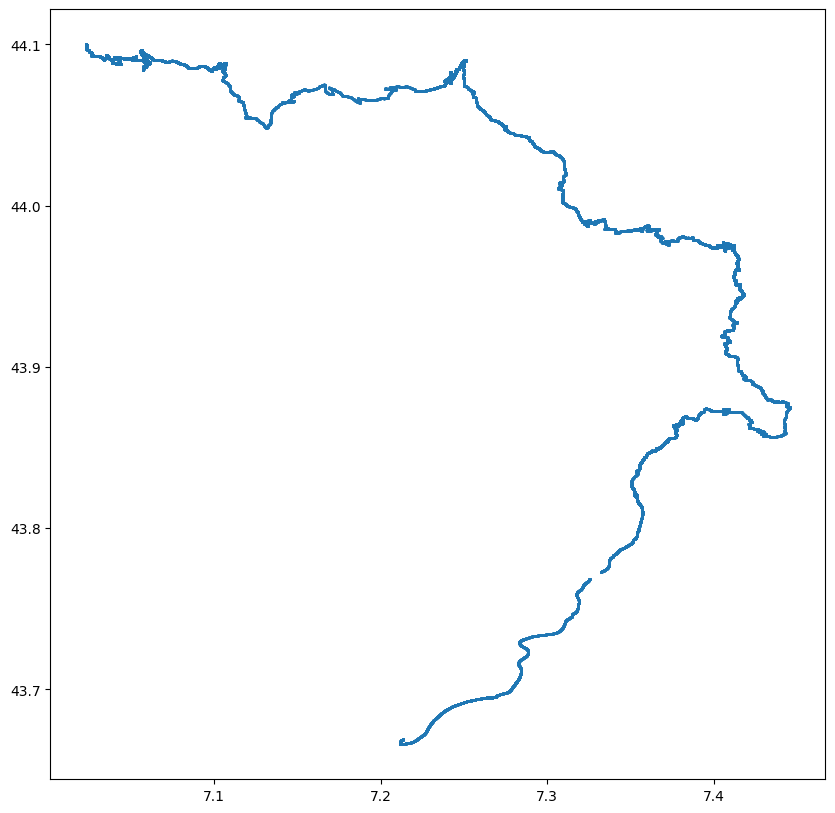

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(df.lon, df.lat, 'o', markersize=1)

time column with time zone causes issues with plotting functions.
Turn the time column into an index

In [8]:
df['time'] = df['time'].dt.tz_localize(None)
df = df.set_index('time')
df.head()

,lat,lon,ele,power,hr,cad,temperature,distance,alt_difference,duration,velocity,gradient
time,,,,,,,,,,,,
2024-07-06 05:03:53,43.669140,7.213582,8.0,18.0,124,53,20.0,NaN,NaN,NaN,NaN,NaN
2024-07-06 05:03:54,43.669136,7.213558,8.0,33.0,124,54,20.0,1.985979,0.0,1.0,7.149523,0.0
2024-07-06 05:03:55,43.669132,7.213534,8.0,108.0,124,56,20.0,1.985979,0.0,1.0,7.149524,0.0
2024-07-06 05:03:56,43.669129,7.213490,8.0,98.0,125,57,20.0,3.564245,0.0,1.0,12.831281,0.0
2024-07-06 05:03:57,43.669117,7.213446,8.0,76.0,125,56,20.0,3.790825,0.0,1.0,13.646968,0.0


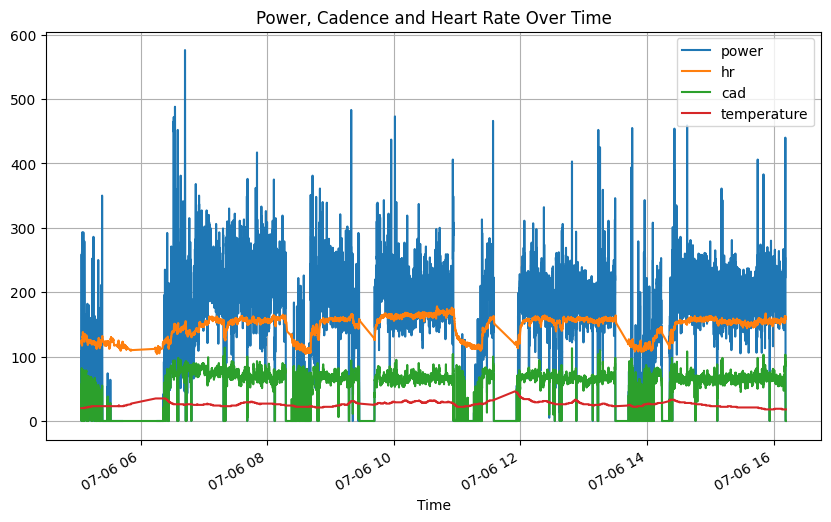

In [9]:
close_px = df[['power','hr','cad','temperature']]
close_px.plot(kind='line',
              figsize=(10, 6),
              title='Power, Cadence and Heart Rate Over Time',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()


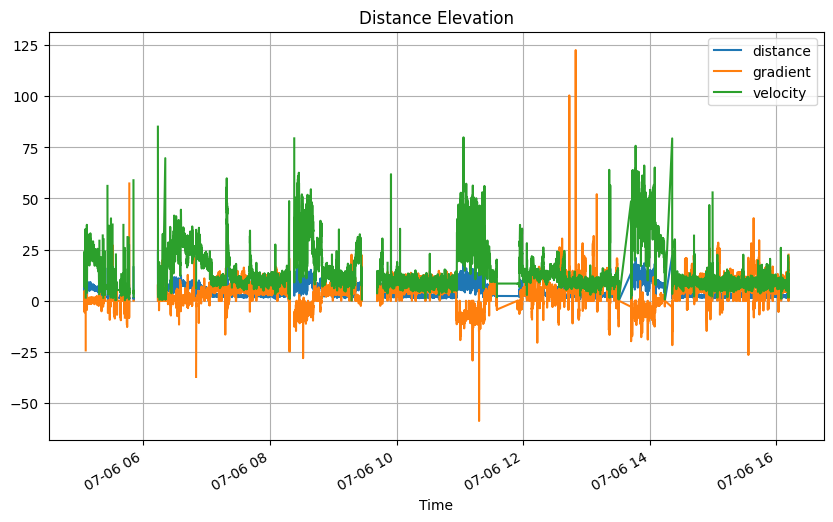

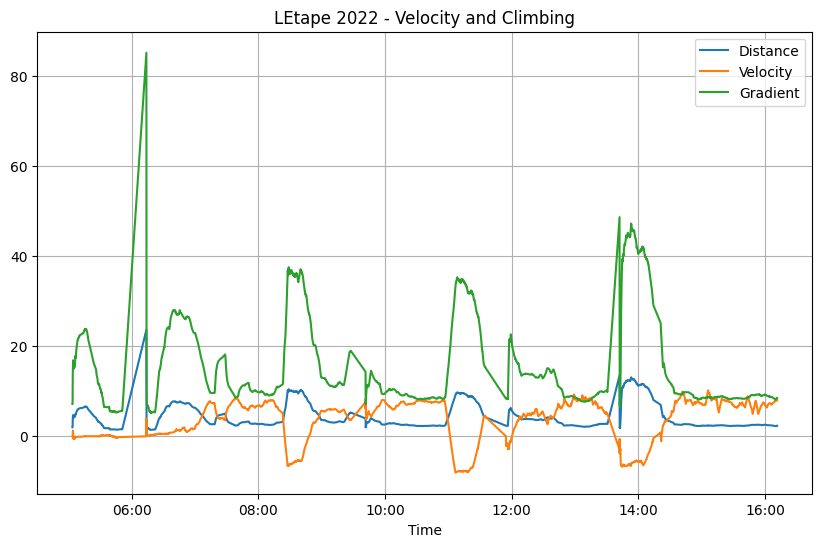

In [10]:
import matplotlib.dates as mdates


move_px = df[['distance','gradient','velocity']]

move_px.plot(kind='line',
              figsize=(10, 6),
              title='Distance Elevation',
              grid=True,
              legend=True)
plt.xlabel('Time')
plt.show()

rolling_mean = move_px.rolling('600s').mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Distance', 'Velocity', 'Gradient'])
plt.title('L''Etape 2022 - Velocity and Climbing')
plt.grid(True)
plt.show()

In [11]:
move_px

,distance,gradient,velocity
time,,,
2024-07-06 05:03:53,NaN,NaN,NaN
2024-07-06 05:03:54,1.985979,0.000000,7.149523
2024-07-06 05:03:55,1.985979,0.000000,7.149524
2024-07-06 05:03:56,3.564245,0.000000,12.831281
2024-07-06 05:03:57,3.790825,0.000000,13.646968
...,...,...,...
2024-07-06 16:11:26,3.697893,8.112729,13.356151
2024-07-06 16:11:27,0.874790,0.000000,3.149242
2024-07-06 16:11:28,0.598186,16.717203,2.183354


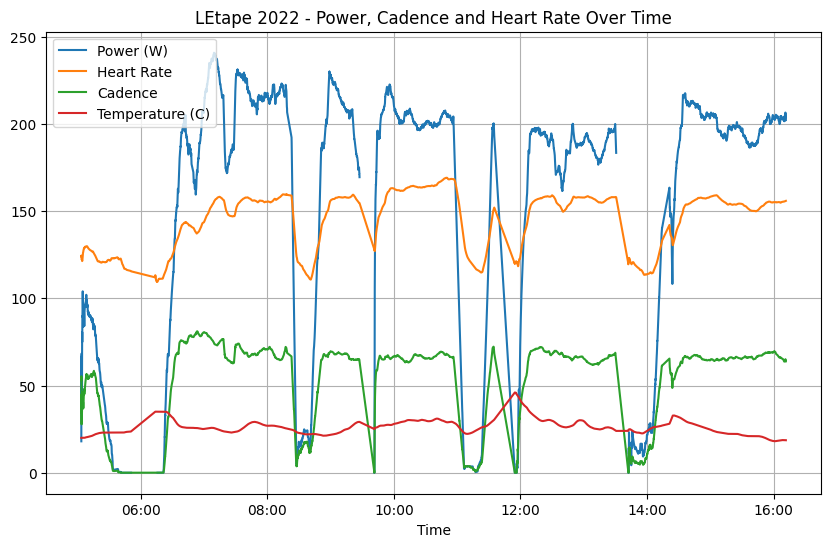

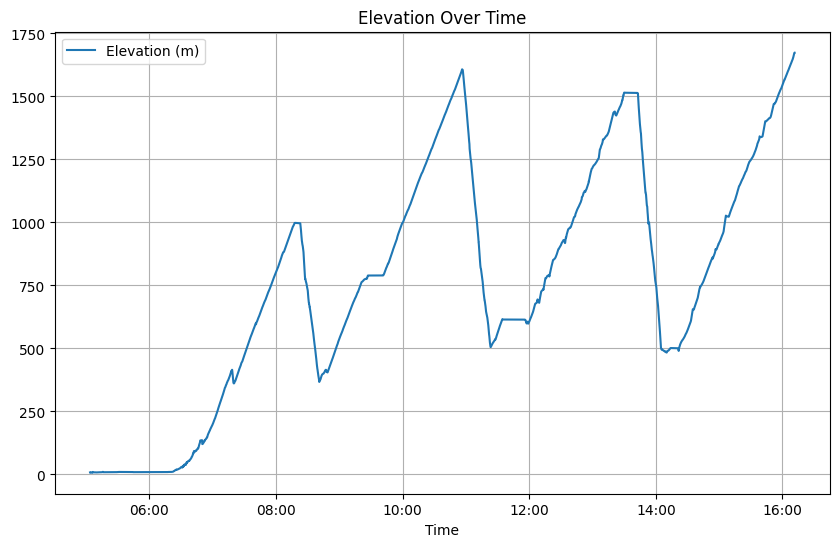

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

rolling_mean = close_px.rolling('600s').mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_mean.index, rolling_mean)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Power (W)', 'Heart Rate', 'Cadence', 'Temperature (C)'])
plt.title('L''Etape 2022 - Power, Cadence and Heart Rate Over Time')
plt.grid(True)
plt.show()

elevation = df[['ele']]
plt.figure(figsize=(10, 6))
plt.plot(elevation.index, elevation)
plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().legend(['Elevation (m)'])
plt.title('Elevation Over Time')
plt.grid(True)
plt.show()

Calculate values for [Physical Activity - Activity-based Measures](https://build.fhir.org/ig/HL7/physical-activity/measures.html#activity-based-measures)

Convert to FHIR Bundle (type = collection)

Remove entries where coasting (cadence < 30)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

strava = df[['power'
    ,'hr'
    ,'cad'
    ,'temperature'
    ,'distance'
    ,'gradient'
    ,'velocity'
             ]].dropna()

print(len(strava))
strava = strava.drop(strava[strava.cad < 30].index)

stravaT = strava[['hr'
    ,'cad'
    ,'temperature'
  #  ,'power'
    ,'gradient'
  #  ,'velocity'
                  ]]
print(len(strava))

X = pd.DataFrame(scale(stravaT))
#y = strava.distance
y = strava.power

print(f"Shape of X: {X.shape}")  # Check original shapes
print(f"Shape of y: {y.shape}")


33366
28245
Shape of X: (28245, 4)
Shape of y: (28245,)


In [14]:
stravaT.mean()

hr             152.950965
cad             68.195928
temperature     26.157479
gradient         5.651480
dtype: float64

In [15]:
stravaT.std()

hr             11.250223
cad             7.794844
temperature     3.838962
gradient        4.981851
dtype: float64

In [16]:
from sklearn.linear_model import LinearRegression

X_Train, X_Test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state = 4200)

lm = LinearRegression()
lm.fit(X_Train,y_train)


print('Linear Regression')
print('=================\n')

print(f"R2 : {lm.score(X_Train, y_train):0.3}")

print('\n')
for coef, column in zip(lm.coef_, stravaT.columns):
    print(f"{column}: {round(coef, 1)}")

Linear Regression

R2 : 0.256


hr: 17.0
cad: 5.9
temperature: -2.4
gradient: 10.3


In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_Train,y_train >= 1)

from sklearn.metrics import accuracy_score

in_sample_acc = accuracy_score(y_train>=35, lr.predict(X_Train))
out_sample_acc = accuracy_score(y_test>=35, lr.predict(X_Test))

print('Logistic Regression')
print('=================\n')

print(f'In sample accurary {in_sample_acc:0.3}')
print(f'Out sample accurary {out_sample_acc:0.3}')

print('\n')

for var, coef,strat in zip(X_Train.columns, lr.coef_[0],stravaT.columns):
    print(f'{strat:11} {var:7} : {coef:0.3}')

print('\n')
print(lr.classes_)

print('\nProbabilities\n',lr.predict_proba(X_Test)[:10,:])

Logistic Regression

In sample accurary 0.992
Out sample accurary 0.994


hr                0 : 0.0567
cad               1 : 0.839
temperature       2 : -0.282
gradient          3 : 0.896


[False  True]

Probabilities
 [[4.77780060e-05 9.99952222e-01]
 [1.81716602e-05 9.99981828e-01]
 [7.02253751e-05 9.99929775e-01]
 [1.42586404e-04 9.99857414e-01]
 [8.31328822e-05 9.99916867e-01]
 [6.28569945e-05 9.99937143e-01]
 [7.33432720e-05 9.99926657e-01]
 [4.21196601e-05 9.99957880e-01]
 [6.89720774e-05 9.99931028e-01]
 [1.18951346e-02 9.88104865e-01]]


In [18]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_Train_scaled = scaler.fit_transform(X_Train)

l2_lm = RidgeCV(alphas=[0.001,0.01,0.1,1,10,100],  cv=5,scoring='r2')
l2_lm.fit(X_Train_scaled,y_train)

best_alpha = l2_lm.alpha_
r2_test = l2_lm.score(X_Test,y_test)

print('RidgeCV')
print('=======\n')

print(f"best alpha is: {best_alpha}")
print(f"test R2: {r2_test:0.3}")
print('\n')

for var, coef,strat in zip(X_Train.columns, l2_lm.coef_,stravaT.columns):
    print(f'{strat:11} {var:7} : {coef:0.3}')

RidgeCV

best alpha is: 100.0
test R2: 0.232


hr                0 : 17.0
cad               1 : 5.89
temperature       2 : -2.39
gradient          3 : 10.3
